In [ ]:
#! -*- coding: utf-8 -*-

In [1]:
%matplotlib inline

import numpy as np

from matplotlib import pyplot as plt

# 事後推定

我々は今、ソースの性質のベイジアン推定に使用するための事後関数を開発しようとしている。 事後密度関数は、観察後の我々のモデルパラメータすべての確率（密度）の分布を記述する。

$$
p(\vec{\theta}|\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}) = \frac{p(\vec{\theta})p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}|\vec{\theta})}{p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\})},
$$

ここで、$\vec{\theta}$には未知のパラメータがすべて含まれており、$\{d_1, d_2,\ldots, d_{\mathrm{N}_f}\}$は私たちのデータ, この場合、$\mathrm{N}_f$個の離散周波数ビンにわたる歪み測定です。

$p(\vec{\theta})$は *prior* であり、コンパクトバイナリの向きが等方的に分散されることを期待しているなど、データを記録する前のパラメータに関する知識が記述されています。 $p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}|\vec{\theta})$は*likelihood*であり、これはもし未知のパラメータのすべてが値$\vec{\theta}$を持っていた時に私たちが見たデータを観察する確率である。 最後に、$p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\})$は *evidence*であり、単純なパラメータ推定では無視できる正規化ですが、 モデル比較の際には有用となる。

ベイジアン推定の取り組みを成功させるためには、観測されたデータ（信号とノイズのプロセス）を（確率的に）記述するためのフォワードモデルが必要です。 今後は、データの内容について強い仮定を設定します。具体的には、既知のパワースペクトル密度を持つ定常なガウスノイズ、および「SEOBNRv4」モデルで説明されているコンパクトバイナリ信号から構成されます。

## データ

具体的な例として、**GW150914**　を含むデータを扱う予定です。 我々は、1kHzについての信号内容がないことを事前に知っているので、データを2048Hzにダウンサンプリングして処理を高速化します。 また、ハンフォードのデータにも注目します。

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


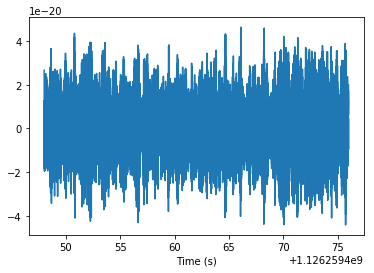

In [2]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)');

# Likelihood

## ノイズモデル

私たちは**GW150914**の周りの時間はよく振舞われていることを知っています。それは定常的でありガウシアンであるという意味です。 つまり、パワースペクトル密度によってノイズの（統計的な）特性を完全に記述することができます。これは、ここ[PyCBC matched filtering exercise](https://git.ligo.org/jonah-kanner/odw-2018/blob/master/pycbc/3_WaveformMatchedFilter.ipynb)に書かれている手順に従ってオフソースデータを使用して推定します

In [3]:
f_lower = 20.
f_upper = 1024.

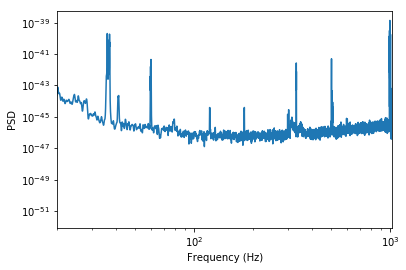

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)

psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

plt.loglog(fs, psd)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD");

これだけです。 私たちは、私たちのノイズが上記のPSDによって正確に記述されていると仮定します。 つまり、0パラメータのノイズモデルを採用しています。

プロダクション分析のために、私たちは[BayesLine](https://arxiv.org/abs/1410.3852)アルゴリズムを使用します。このアルゴリズムは、PSD自体のパラメトリックモデルを採用しており、オンソースデータのみで作業することができます。

## シグナルのモデル

我々は、解析的な近似と数値的相対性理論のシミュレーションとの組み合わせを用いて、バイナリブラックホールマージャーのインスパイラル、マージ、およびリングダウンのフェーズを記述する `SEOBNRv4`近似を使用するつもりです。

In [5]:
from pycbc import filter
from pycbc.types import Array

from pycbc.waveform import get_td_waveform

簡単のために、私たちは等質量のバイナリを仮定しますが、これはデータとコンシステント（しかし要求されない）なことを知ってます。

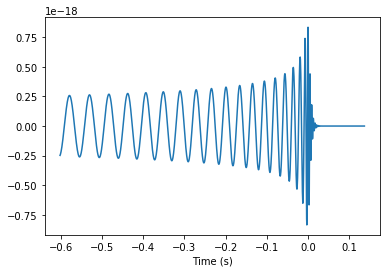

In [6]:
m = 36. # Solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

`get_td_waveform（）`は歪みの2つの偏波を返します。 今のところ、我々はプラス偏光を使います。

可視化のために（そして解析で「何が見えるか」を入念に調べるのに）、データがフィルタリングされてフラットなPSDを生成するホワイトニングされたデータを見ると便利です。

詳しくはここ[PyCBC matched filtering exercise](https://git.ligo.org/jonah-kanner/odw-2018/blob/master/pycbc/3_WaveformMatchedFilter.ipynb) を見てください。

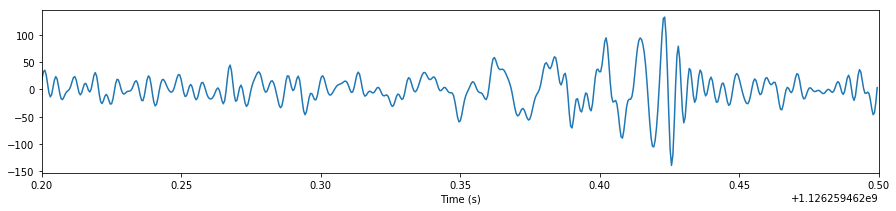

In [7]:
white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data)
plt.xlim(merger.time-.2, merger.time+.1)
plt.xlabel('Time (s)');

今度は、パラメータベクトル$\vec{\theta}$をとり、私たちのデータと同じサンプリングレートと時間ウィンドウを持つ波形を生成する `get_td_waveform（）`の軽量ラッパーを作成します。 ここでは、コンポーネントの質量（等量バイナリを仮定）、距離、マージャーの時間とフェーズを変えることを計画します。

私たちは1つの検出器でしか作業していないので、我々は1つの偏波に敏感であり、アンテナパターンのどこに電波源があるのかを知ることはできません。 これは、傾きに敏感ではないことを意味します。距離が完全に縮退しているため、ここで測定するのは実際には距離ではありませんが、バイナリの距離は、 検出器の真上にあった時のものです。

In [8]:
def gen_template(theta,
                 delta_t=strain.delta_t,
                 duration=strain.duration,
                 start_time=strain.start_time,
                 f_lower=f_lower):
    
    m, distance, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m,
                             mass2=m,
                             distance=distance,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain.start_time)
    hp.start_time = strain.start_time

    return hp

## 一つの検出器のLikelihood

これで、モデルのすべてのパラメータに特定の値が与えられれば、尤度関数を定義できるようになりました。

確率的なデータの成分は、ノイズから完全に来る。 ソースパラメータ$\vec{\theta}$を推測すると、PSDで記述されたノイズプロセスから得られた残差（モデル信号を差し引いたデータ）の確率の統計的尺度となります。

$$
p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\}|\vec{\theta}) = \exp \left(-\frac{1}{2}\langle h(\vec{\theta})-d|h(\vec{\theta})-d\rangle\right),
$$

ここで$\langle\rangle$は内積です:

$$
\langle a|b\rangle = 4 \Re \int_0^\infty \frac{a(f)b(f)}{S_n(f)}df,
$$

ここで $S_n(f)$ は検出器のPSDです。　ノイズのみの仮説は:

$$
p(\{d_1, d_2, \ldots, d_{\mathrm{N}_f}\} | n) = \exp \left( -\frac{1}{2}\sum_i^{\mathrm{N}_f}\langle d_i|d_i\rangle\right),
$$

となる。

これにより尤度比を求めることにより、ノイズの可能性に対する$\vec{\theta}$で記述される信号の尤度の比である尤度比を得ることができます。 とにかく尤度の正規化について心配していないので、尤度比で作業します。最大化すると、$\mathrm{SNR}^2/2$に等しくなければならないという優れた特徴があるからです。

周波数領域で作業しているので、事前にデータを一度FFT処理します。

In [9]:
# FFT the data once, ahead of time
df = strain.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_lower, f_upper=f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_lower)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    logl = -0.5*(hh - 2.0*dh)

    return logl

私たちはこれからたくさんのことをするので、後で時間を節約するために、いくつかのホワイトニングとプロット関数を定義しましょう。

In [10]:
def whiten_trim_template(template, psd=psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_template

def plot_whitened_strains(strain, template):
    white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(merger.time-.2, merger.time+.1)
    plt.legend()

次に、ある程度値のわかっているモデルパラメータのいくつかを選択し、モデル信号を生成しましょう。 それを白化してデータと比較し、尤度を計算します。

-479.247013755


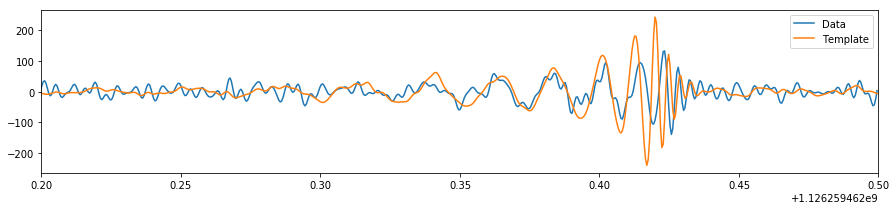

In [11]:
# m, distance, time, phase
theta0 = [36., 462., float(merger.time)+.02, 0.]

template0 = gen_template(theta0)
plot_whitened_strains(strain, template0)

print(loglikelihood(theta0))

次に、最適な信号を見つける可能性を最大化しましょう。 Powell法を使ってscipyが提供する `minimize（）`関数を使用します。なぜなら、非平滑関数を処理するのにはかなり良いアルゴリズムだからです。 また、コールバック関数を定義して、尤度値を出力し、モデルが動作するようにプロットします。

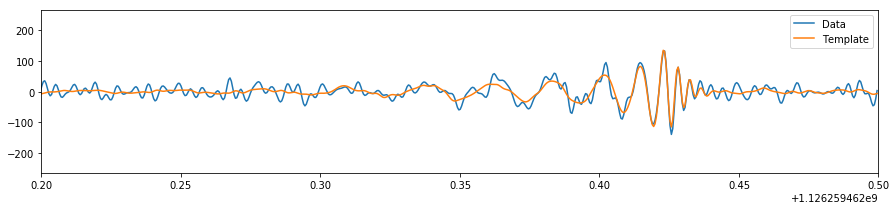

Steps	log(likelihood)
10	183.717


In [12]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim_template(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label="Data")
line, = plt.plot(whitened_template.sample_times, whitened_template, label="Template")

plt.xlim(merger.time-.2, merger.time+.1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

これで、ベストフィットの波形が得られました。そして、データはかなり良く一致しています（少なくとも目で見る限り）。

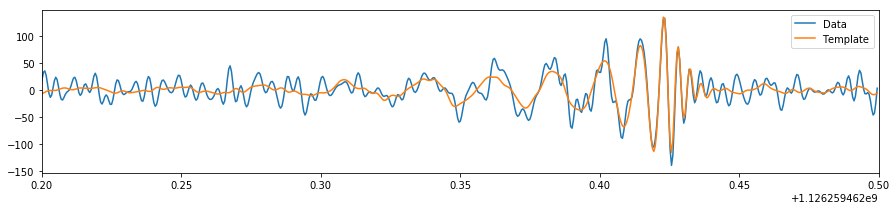

In [13]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

plot_whitened_strains(strain, best_fit_template)

さて、データからそれを差っ引いて、残差がノイズとどれほど一貫しているかを見てみましょう。

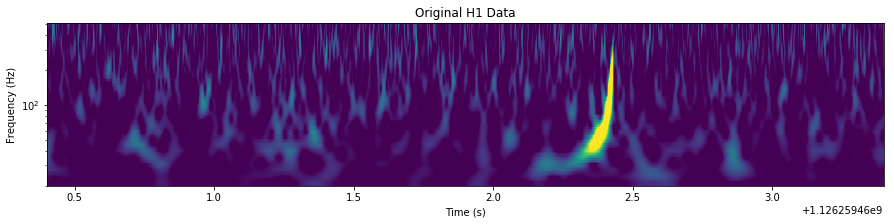

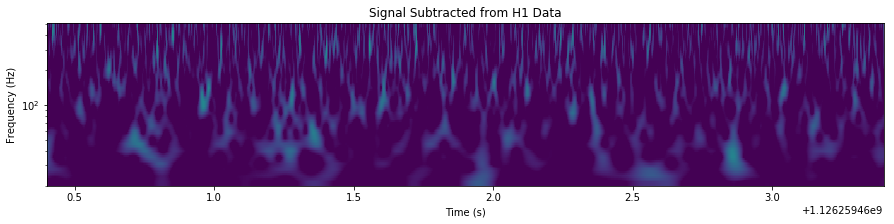

In [14]:
subtracted = strain - best_fit_template

# Plot the original data and the subtracted signal data

for data, title in [(strain, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                          logfsteps=100,
                                          qrange=(8, 8),
                                          frange=(20, 512))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - 2, merger.time + 1)

## ネットワークLikelihood

これまでは1つの検出器でしか作業していませんでしので、推論能力はこれによって制限されていました。

GW検出器ネットワーク（この場合は2つのLIGO計測器）の尤度関数を構築するために、雑音が検出器間で独立しているという非常に合理的な仮定を立てる。 これは、ネットワーク尤度関数が単検出器尤度関数の積であることを意味します。
$$
\log \mathcal{L}_\mathrm{net} = \sum_{j \in \{\mathrm{H1}, \mathrm{L1}\}} \log \mathcal{L}_\mathrm{j}
$$

**GW150914**のLivingstonのデータを取得しましょう。

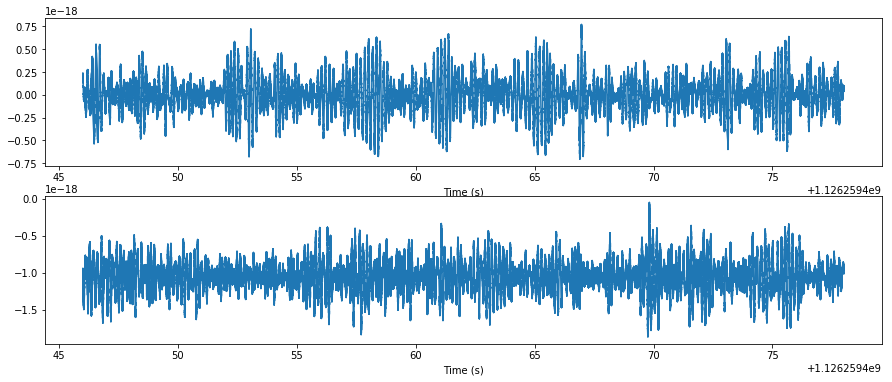

In [15]:
from pycbc.detector import Detector

dets = ['H1', 'L1']

# Get the data from the Hanford detector
strains = dict([(det, merger.strain(det)) for det in dets])

# Remove the low frequency content and downsample the data to 2048Hz
for det, strain in strains.iteritems():
    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048).crop(2, 2)

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
for ax, det in zip(axs, dets):
    ax.plot(strains[det].sample_times, strains[det])
    ax.set_xlabel('Time (s)')

各検出器ごとに個別のPSDを計算する必要があります。

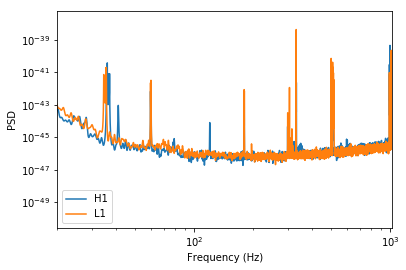

In [16]:
psds = {}

for det in dets:
    psd = strains[det].psd(4)
    psd = interpolate(psd, strains[det].delta_f)

    psds[det] = inverse_spectrum_truncation(psd, 4 * strain.sample_rate)

fs = psd.delta_f * np.arange(psd.data.size)

for det in dets:
    plt.loglog(fs, psds[det], label=det)
plt.xlim(f_lower, f_upper)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.legend(loc='lower left');

白色化したデータを見てみましょう。

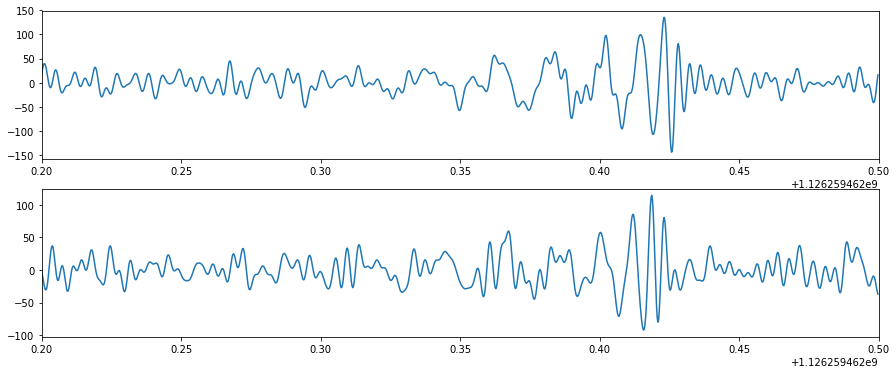

In [17]:
white_net_data = {}
for det in dets:
    white_net_data[det] = (strains[det].to_frequencyseries() / psds[det]**0.5).to_timeseries()
    white_net_data[det] = white_net_data[det].highpass_fir(30., 512).lowpass_fir(300, 512)
    white_net_data[det] = white_net_data[det].time_slice(merger.time-.2, merger.time+.1)
    
fig, axs = plt.subplots(2, 1, figsize=[15, 6])

for ax, det in zip(axs, dets):
    ax.plot(white_net_data[det].sample_times, white_net_data[det])

    ax.set_xlim(merger.time-.2, merger.time+.1)

2つの検出器を用いることにより、重力波の1つ以上の偏光に敏感に反応する可能性があります。我々はまた、信号源がどこにあるのかに基づいて信号が到着する時間の遅延を考慮する必要があります。これは、成分質量（等しい質量二乗を仮定する）、RA、DEC、光度距離、傾き、マージャー時間、マージャー位相、および偏光角にパラメータを拡張する。

与えられたパラメータ$\vec{\theta}$に対して、GWエミッションのプラス偏波とクロス偏波を生成する必要があります（バイナリの傾斜を考慮し、適切な距離にスケーリングする）これらは各検出器のアンテナパターン（検出器の向きに対する2進法の位置に依存する）を用いて検出器の応答を決定する。最後に、信号の到着時刻を、バイナリのRAとDECに基づいて予測される遅延時間と一致するようにシフトさせる必要があります。

簡単に言えば、プロセスは地理座標波形を生成してネットワークに投影するものと考えることができます。

In [18]:
def net_gen_template(theta, dets=['H1', 'L1'],
                     delta_t=strains['H1'].delta_t,
                     duration=strains['H1'].duration,
                     start_time=strains['H1'].start_time,
                     f_lower=f_lower):
    m, ra, dec, distance, inclination, time, coa_phase, polarization = theta

    # generate geocenter waveform
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m,
                             mass2=m,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=coa_phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    hp.resize(len(strain))
    hc.resize(len(strain))
    hp = hp.cyclic_time_shift(hp.start_time + time - start_time)
    hc = hc.cyclic_time_shift(hc.start_time + time - start_time)

    # project geocenter waveform onto detectors
    h = {}
    for det in dets:
        ifo = Detector(det)
        fp, fc = ifo.antenna_pattern(ra, dec, polarization, time)
        ifo_h = fp*hp.copy() + fc*hc.copy()
        dt = ifo.time_delay_from_earth_center(ra, dec, time)
        h[det] = ifo_h.cyclic_time_shift(dt)
        h[det].start_time = start_time
    return h

ここで定義されたネットワーク波形発生器を用いて、単一検出器尤度関数の積の尤度関数を定義することができる。

In [19]:
# FFT the data once, ahead of time
dfs = dict([(det, strain.to_frequencyseries()) for det, strain in strains.iteritems()])

def net_loglikelihood(theta, dfs=dfs, psds=psds, f_lower=f_lower, f_upper=f_upper):
    dets = dfs.keys()
    logl = 0
    
    # assume identical sampling rates, sampling times, etc.
    df = dfs[dets[0]]
    delta_t = df.delta_t
    duration = df.duration
    N = int(duration/delta_t)
    start_time = df.start_time
    
    # Return p=0 if waveform generation fails
    try:
        hts = net_gen_template(theta, dets=dets, delta_t=delta_t, duration=duration, start_time=start_time, f_lower=f_lower)
    except RuntimeError:
        return -np.inf
    
    # Sum over single-detector likelihoods
    for det, df in dfs.iteritems():
        psd = psds[det]
        hf = hts[det].to_frequencyseries()

        kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

        hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
        logl += -0.5*(hh - 2.0*dh)

    return logl

ここでも、パラメータのいくつかの値をありそうな値に適当に選択し、データと比較することができます。

In [20]:
# m, ra, dec, distance, inclination, time, coa_phase, polarization
theta0 = [36., 2.2, -1.2, 400., np.pi, float(merger.time)+.008, 0., 0.]

net_loglikelihood(theta0)

-23.301454416173016

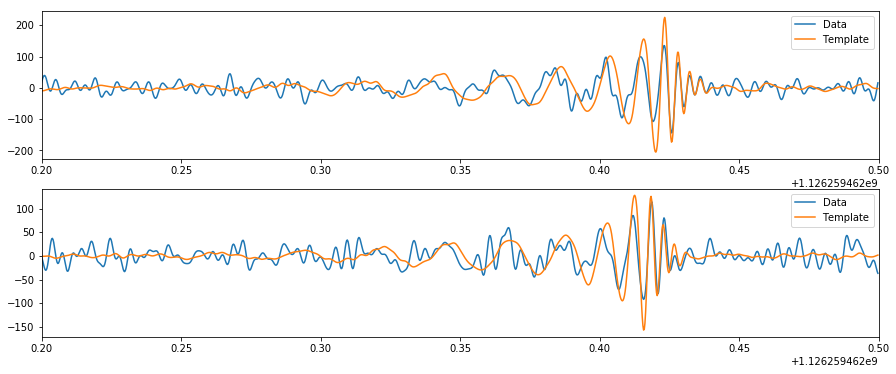

In [21]:
hts = net_gen_template(theta0)
fig, axs = plt.subplots(2, 1, figsize=[15, 6])

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

さあ、ネットワークの尤度を最大化して、ベストフィットモデルがいかによくシグナルを取り除くかを見てみましょう。

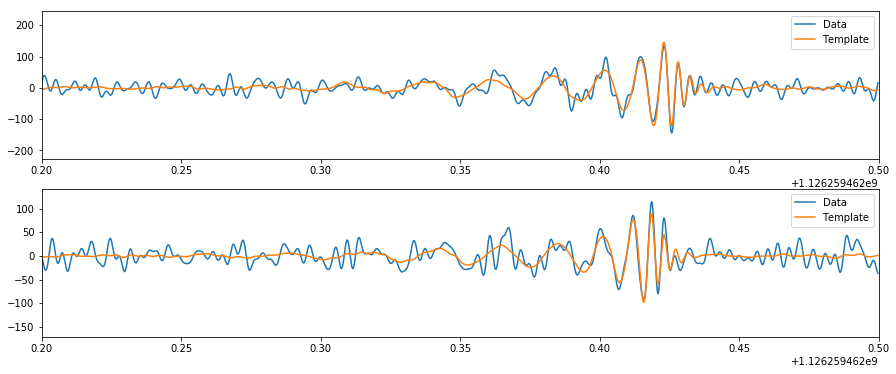

Steps	log(likelihood)
7	284.838


In [22]:
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim_template(templates[det], psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, net_loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -net_loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

In [23]:
best_fit = res.x
best_fit_templates = net_gen_template(best_fit, start_time=strains["H1"].start_time)

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))

for i, det in enumerate(dets):
    subtracted = strains[det] - best_fit_templates[det]

    # Plot the original data and the subtracted signal data
    for ax, data, title in [(axs[0][i], strains[det], 'Original {} Data'.format(det)),
                        (axs[1][i], subtracted, 'Signal Subtracted from {} Data'.format(det))]:

        t, f, p = data.whiten(4, 4).qtransform(.001,
                                              logfsteps=100,
                                              qrange=(8, 8),
                                              frange=(20, 512))
        ax.set_title(title)
        ax.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlim(merger.time - 2, merger.time + 1)
plt.tight_layout()

# 事前確率

これまでのところ、尤度に焦点を当てていましたが、ベイズ推定にとっても同様に重要なことは、私の事前確率、測定値を取る*前*に持っていたモデルパラメータの分布の知識です。

事前確率を指定せずに上で定義した尤度関数をサンプリングすると、モデルのパラメータには一様な確率が暗黙的に採用されます。 言い換えれば、別のパラメータ化で同じ尤度をサンプリングする場合、私たちは暗黙のうちに*異なる*事前確率を使用して解析することになります。

いくつかのパラメータ（例えば、マージャー時間、マージャー位相など）については、一様な事前確率が正当化される一方で、ソースが一次近似ではローカルユニバースに均一に配分されることを前提とする必要があります。

$$
p(\alpha, \delta) \propto \cos(\delta),
$$

ここで、 $\delta \in [-\pi/2, \pi/2]$ はソースの赤緯、

$$
p(D, \iota) \propto D^2\sin(\iota)
$$

ここで、 $D$　はソースの輝度距離、 $\iota$ はバイナリの傾き角度です。

In [ ]:
def logprior(theta):
    logp = 0
    
    m, ra, dec, distance, inclination, time, coa_phase, polarization = theta
    
    for angle in [ra, coa_phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf
    
    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    return logp

# 事後確率
ネットワーク尤度と事前確率が定義されていれば、私たちはその積を取って事後確率を計算することができます。

In [ ]:
def logposterior(theta, **kwargs):
    logpost = logprior(theta)
    if np.isfinite(logpost):
        logpost += net_loglikelihood(theta)
    return logpost

In [ ]:
logposterior(theta0)

事後確率を最大化して、*最大事後パラメータ*（MAP）を決定することができます。

データと最も整合性のあるモデルを生成するパラメータを見つけたという意味で、最尤ポイントが「最適」であった場合、MAPは、データと一致するようにデータのバランスをとるという点で、ソースパラメータに対する事前の期待に一致する「最良の推測」になります。

In [ ]:
Neval = 1

fig, axs = plt.subplots(2, 1, figsize=[15, 6])

hts = net_gen_template(theta0)

lines = {}
for ax, det in zip(axs, dets):
    whitened_template = whiten_trim_template(hts[det], psds[det])

    ax.plot(white_net_data[det].sample_times, white_net_data[det], label="Data")
    lines[det], = ax.plot(whitened_template.sample_times, whitened_template, label="Template")

    ax.set_xlim(merger.time-.2, merger.time+.1)
    ax.legend()

def callback(thetai):
    global Neval
    global lines
    global fig
    
    templates = net_gen_template(thetai)
    for det in dets:
        white_template = whiten_trim_template(templates[det], psds[det])
        lines[det].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -logposterior(theta), theta0, callback=callback, method='powell')
plt.close()

In [ ]:
best_guess = res.x
print(best_guess)

# 事後サンプリング

これまで、ソースパラメータのポイント推定値を生成していましたが、これば誤差を定量化するためでした。 我々の事後関数が定義されると、この確率密度関数からサンプルを引き出すためにマルコフ連鎖モンテカルロサンプラーにプラグインすることができる。

事後確率密度関数があれば、既製のサンプラー、例えば[emcee](http://dfm.io/emcee/current/) や [kombine](http://pages.uoregon.edu/bfarr/kombine/) を使用してサンプリングできる